In [8]:

#mount drive
from google.colab import drive
drive.mount('/content/MyDrive')
import seaborn as sns
sns.set_theme("paper")



Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [9]:
# @title Initialize Config

import torch
import numpy
class Config:
    def __init__(self, **kwargs):
        self.channels_imu_acc = kwargs.get('channels_imu_acc', [])
        self.channels_imu_gyr = kwargs.get('channels_imu_gyr', [])
        self.channels_joints = kwargs.get('channels_joints', [])
        self.channels_emg = kwargs.get('channels_emg', [])
        self.seed = kwargs.get('seed', 42)
        self.data_folder_name = kwargs.get('data_folder_name', 'default_data_folder_name')
        self.dataset_root = kwargs.get('dataset_root', 'default_dataset_root')
        self.imu_transforms = kwargs.get('imu_transforms', [])
        self.joint_transforms = kwargs.get('joint_transforms', [])
        self.emg_transforms = kwargs.get('emg_transforms', [])
        self.input_format = kwargs.get('input_format', 'csv')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config(
    data_folder_name='/content/MyDrive/MyDrive/sd_datacollection_v4/all_subjects_data_final.h5',
    dataset_root='/content/datasets',
    input_format="csv",
    channels_imu_acc=['ACCX1', 'ACCY1', 'ACCZ1','ACCX2', 'ACCY2', 'ACCZ2', 'ACCX3', 'ACCY3', 'ACCZ3', 'ACCX4', 'ACCY4', 'ACCZ4', 'ACCX5', 'ACCY5', 'ACCZ5', 'ACCX6', 'ACCY6', 'ACCZ6'],
    channels_imu_gyr=['GYROX1', 'GYROY1', 'GYROZ1', 'GYROX2', 'GYROY2', 'GYROZ2', 'GYROX3', 'GYROY3', 'GYROZ3', 'GYROX4', 'GYROY4', 'GYROZ4', 'GYROX5', 'GYROY5', 'GYROZ5', 'GYROX6', 'GYROY6', 'GYROZ6'],
    channels_joints=['elbow_flex_r', 'arm_flex_r', 'arm_add_r'],
    channels_emg=['IM EMG4', 'IM EMG5', 'IM EMG6'],
)

#set seeds
torch.manual_seed(config.seed)
numpy.random.seed(config.seed)


In [10]:
class DataSharder:
    def __init__(self, config, split):
        self.config = config
        self.h5_file_path = config.data_folder_name  # Path to the HDF5 file
        self.split = split

    def load_data(self, subjects, window_length, window_overlap, dataset_name):
        print(f"Processing subjects: {subjects} with window length: {window_length}, overlap: {window_overlap}")

        self.window_length = window_length
        self.window_overlap = window_overlap

        # Process the data from the HDF5 file
        self._process_and_save_patients_h5(subjects, dataset_name)

    def _process_and_save_patients_h5(self, subjects, dataset_name):
        # Open the HDF5 file
        with h5py.File(self.h5_file_path, 'r') as h5_file:
            dataset_folder = os.path.join(self.config.dataset_root, dataset_name, self.split).replace("subject", "").replace("__", "_")
            print("Dataset folder:", dataset_folder)

            if os.path.exists(dataset_folder):
                print("Dataset Exists, Skipping...")
                return

            os.makedirs(dataset_folder, exist_ok=True)
            print("Dataset folder created: ", dataset_folder)

            for subject_id in tqdm(subjects, desc="Processing subjects"):
                subject_key = subject_id
                if subject_key not in h5_file:
                    print(f"Subject {subject_key} not found in the HDF5 file. Skipping.")
                    continue

                subject_data = h5_file[subject_key]
                session_keys = list(subject_data.keys())  # Sessions for this subject

                for session_id in session_keys:
                    session_data_group = subject_data[session_id]

                    for sessions_speed in session_data_group.keys():
                        session_data = session_data_group[sessions_speed]

                        # Extract IMU, EMG, and Joint data as numpy arrays
                        imu_data, imu_columns = self._extract_channel_data(session_data, self.config.channels_imu_acc + self.config.channels_imu_gyr)
                        emg_data, emg_columns = self._extract_channel_data(session_data, self.config.channels_emg)
                        joint_data, joint_columns = self._extract_channel_data(session_data, self.config.channels_joints)

                        # Shard the data into windows and save each window
                        self._save_windowed_data(imu_data, emg_data, joint_data, subject_key, session_id,sessions_speed, dataset_folder, imu_columns, emg_columns, joint_columns)

    def _save_windowed_data(self, imu_data, emg_data, joint_data, subject_key, session_id, session_speed, dataset_folder, imu_columns, emg_columns, joint_columns):
        window_size = self.window_length
        overlap = self.window_overlap
        step_size = window_size - overlap

        # Path to the CSV log file
        csv_file_path = os.path.join(dataset_folder, '..', f"{self.split}_info.csv")

        # Ensure the folder exists
        os.makedirs(dataset_folder, exist_ok=True)

        # Prepare CSV log headers (ensure the columns are 'file_name' and 'file_path')
        csv_headers = ['file_name', 'file_path']

        # Create or append to the CSV log file
        file_exists = os.path.isfile(csv_file_path)
        with open(csv_file_path, mode='a', newline='') as csv_file:
            writer = csv.writer(csv_file)

            # Write the headers only if the file is new
            if not file_exists:
                writer.writerow(csv_headers)

            # Determine the total data length based on the minimum length across the data sources
            total_data_length = min(imu_data.shape[1], emg_data.shape[1], joint_data.shape[1])

            # Adjust the starting point for windows based on total data length
            start = 2000 if total_data_length > 4000 else 0

            # Ensure that each window across imu_data, emg_data, and joint_data has the same shape before concatenation
            for i in range(start, total_data_length - window_size + 1, step_size):
                imu_window = imu_data[:, i:i + window_size]
                emg_window = emg_data[:, i:i + window_size]
                joint_window = joint_data[:, i:i + window_size]

                # Check if the window sizes are valid
                if imu_window.shape[1] == window_size and emg_window.shape[1] == window_size and joint_window.shape[1] == window_size:
                    # Convert windowed data to pandas DataFrame



                    imu_df = pd.DataFrame(imu_window.T, columns=imu_columns)
                    emg_df = pd.DataFrame(emg_window.T, columns=emg_columns)
                    joint_df = pd.DataFrame(joint_window.T, columns=joint_columns)



                    # Concatenate the data along the column axis
                    combined_df = pd.concat([imu_df, emg_df, joint_df], axis=1)

                    # Save the combined windowed data as a CSV file
                    file_name = f"{subject_key}_{session_id}_{session_speed}_win_{i}_ws{window_size}_ol{overlap}.csv"
                    file_path = os.path.join(dataset_folder, file_name)
                    combined_df.to_csv(file_path, index=False)

                    # Log the file name and path in the CSV (in the correct columns)
                    writer.writerow([file_name, file_path])
                else:
                    print(f"Skipping window {i} due to mismatched window sizes.")

    def _extract_channel_data(self, session_data, channels):
      extracted_data = []
      new_column_names = []  # Initialize here

      if isinstance(session_data, h5py.Dataset):
          if session_data.dtype.names:
              # Compound dataset
              column_names = session_data.dtype.names
              for channel in channels:
                  if channel in column_names:
                      channel_data = session_data[channel][:]
                      channel_data = pd.to_numeric(channel_data, errors='coerce')
                      df = pd.DataFrame(channel_data)
                      df_interpolated = df.interpolate(method='linear', axis=0, limit_direction='both')
                      extracted_data.append(df_interpolated.to_numpy().flatten())
                      new_column_names.append(channel)  # Populate here
                  else:
                      print(f"Channel {channel} not found in compound dataset.")
          else:
              # Simple dataset
              column_names = list(session_data.attrs.get('column_names', []))
              assert len(column_names) > 0, "column_names not found in dataset attributes"
              for channel in channels:
                  if channel in column_names:
                      col_idx = column_names.index(channel)
                      channel_data = session_data[:, col_idx]
                      channel_data = pd.to_numeric(channel_data, errors='coerce')
                      df = pd.DataFrame(channel_data)
                      df_interpolated = df.interpolate(method='linear', axis=0, limit_direction='both')
                      extracted_data.append(df_interpolated.to_numpy().flatten())
                      new_column_names.append(channel)
                  else:
                      print(f"Channel {channel} not found in session data.")

      return np.array(extracted_data), new_column_names


In [20]:
# File: dataset.py

from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
import os

class ImuJointPairDataset(Dataset):
    def __init__(
        self,
        config,
        subjects,
        window_length,
        window_overlap,
        split='train',
        feature_stats=None,
        dataset_train_name='train',
        dataset_test_name='test'
    ):
        self.config = config
        self.split = split
        self.subjects = subjects
        self.window_length = window_length
        self.window_overlap = window_overlap if split == 'train' else 0
        self.input_format = config.input_format
        self.channels_imu_acc = config.channels_imu_acc
        self.channels_imu_gyr = config.channels_imu_gyr
        self.channels_joints = config.channels_joints
        self.channels_emg = config.channels_emg

        # Optional feature statistics for normalization (used for obs only)
        self.feature_stats = feature_stats

        # You can adjust these ranges to match actual human-motion bounds
        self.joint_ranges = {
            'elbow_flex_r': (0, 150),   # Example: elbow flex from 0 to 150 deg
            'arm_flex_r':   (-90, 180),
            'arm_add_r':    (-120, 90)
        }

        subjects_str = "_".join(map(str, subjects)).replace('subject', '').replace('__', '_')
        if split == 'train':
            dataset_name = f"dataset_wl{self.window_length}_ol{self.window_overlap}_train{subjects_str}"
        else:
            dataset_name = f"dataset_wl{self.window_length}_ol{self.window_overlap}_test{subjects_str}"
        self.dataset_name = dataset_name
        self.root_dir = os.path.join(self.config.dataset_root, self.dataset_name)

        # Prepare sharded data if not found
        self.ensure_resharded(subjects, dataset_train_name if split == 'train' else dataset_test_name)

        # Load info CSV
        info_path = os.path.join(self.root_dir, f"{split}_info.csv")
        self.data = pd.read_csv(info_path)

        # If training set and no feature_stats passed, compute obs stats here
        if split == 'train' and feature_stats is None:
            self.feature_stats = self.compute_feature_stats()

    def ensure_resharded(self, subjects, dataset_name):
        if not os.path.exists(self.root_dir):
            print(f"Sharded data not found at {self.root_dir}. Resharding...")
            data_sharder = DataSharder(self.config, self.split)
            data_sharder.load_data(
                subjects,
                window_length=self.window_length,
                window_overlap=self.window_overlap,
                dataset_name=self.dataset_name
            )
        else:
            print(f"Sharded data found at {self.root_dir}. Skipping resharding.")

    def compute_feature_stats(self):
        all_obs = []
        # We won't do standard stats on joints since we'll manually min-max scale them
        for idx in range(len(self.data)):
            obs_data, _ = self.__getitem__(idx, normalize=False)
            # obs_data is shape (#windows, window_length, obs_channels)
            # We'll flatten across windows/time to get a single large array
            obs_data_flat = obs_data.reshape(-1, obs_data.shape[-1])
            all_obs.append(obs_data_flat)
        all_obs = np.vstack(all_obs)
        obs_stats = {'mean': np.mean(all_obs, axis=0), 'std': np.std(all_obs, axis=0)}
        return {'obs': obs_stats}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx, normalize=True):
        file_name = self.data.iloc[idx, 0]
        file_path = os.path.join(self.root_dir, self.split, file_name)
        if self.input_format == "csv":
            combined_data = pd.read_csv(file_path)
        else:
            raise ValueError("Unsupported input format")

        obs_data, joint_data = self._extract_and_transform(combined_data, normalize)
        obs_windows = self.create_windows(obs_data, self.window_length, self.window_overlap)
        joint_windows = self.create_windows(joint_data, self.window_length, self.window_overlap)
        return obs_windows, joint_windows

    def create_windows(self, data, window_length, window_overlap):
        stride = window_length - window_overlap
        return np.array([
            data[i:i + window_length] for i in range(0, len(data) - window_length + 1, stride)
        ])

    def _extract_and_transform(self, combined_data, normalize):
        imu_data_acc = self._extract_channels(combined_data, self.channels_imu_acc)
        imu_data_gyr = self._extract_channels(combined_data, self.channels_imu_gyr)
        emg_data = self._extract_channels(combined_data, self.channels_emg)
        joint_data = self._extract_channels(combined_data, self.channels_joints)

        obs_data = np.concatenate([imu_data_acc, imu_data_gyr, emg_data], axis=1)

        if normalize and self.feature_stats:
            obs_stats = self.feature_stats['obs']
            obs_data = (obs_data - obs_stats['mean']) / obs_stats['std']

            # Manually scale each joint channel to [-1, 1]
            for i, channel in enumerate(self.channels_joints):
                min_val, max_val = self.joint_ranges[channel]
                joint_data[:, i] = 2.0 * (joint_data[:, i] - min_val) / (max_val - min_val) - 1.0

        return obs_data, joint_data

    def _extract_channels(self, combined_data, channels):
        if self.input_format == "csv":
            return combined_data[channels].values
        raise ValueError("Unsupported format")


def create_base_data_loaders(
    config,
    train_subjects,
    test_subjects,
    window_length=100,
    window_overlap=75,
    batch_size=64,
    dataset_train_name='train',
    dataset_test_name='test'
):
    # Create the training dataset and compute feature statistics
    train_dataset = ImuJointPairDataset(
        config=config,
        subjects=train_subjects,
        window_length=window_length,
        window_overlap=window_overlap,
        split='train',
        dataset_train_name=dataset_train_name
    )
    feature_stats = train_dataset.feature_stats  # Save computed stats

    # Create the test dataset with normalization stats from training
    test_dataset = ImuJointPairDataset(
        config=config,
        subjects=test_subjects,
        window_length=window_length,
        window_overlap=0,  # Ensure no overlap for test
        split='test',
        feature_stats=feature_stats,  # Use training stats for normalization
        dataset_test_name=dataset_test_name
    )

    # Split training dataset into train and validation sets
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    # Assign training stats to the validation dataset
    val_dataset.dataset.feature_stats = feature_stats

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader



In [12]:
# Full Training Pipeline with Dataloaders, Model, and Training
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torch.optim import AdamW
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.training_utils import EMAModel
from tqdm import tqdm
import os
import h5py
import pandas as pd
import numpy as np
import csv
import math


class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class Downsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, stride=2, padding=1)
    def forward(self, x):
        return self.conv(x)

class Upsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, kernel_size=4, stride=2, padding=1)
    def forward(self, x):
        return self.conv(x)

class Conv1dBlock(nn.Module):
    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(inp_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.GroupNorm(n_groups, out_channels),
            nn.Mish(),
        )
    def forward(self, x):
        return self.block(x)

class ConditionalResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, cond_dim, kernel_size=3, n_groups=8):
        super().__init__()
        self.blocks = nn.ModuleList([
            Conv1dBlock(in_channels, out_channels, kernel_size, n_groups),
            Conv1dBlock(out_channels, out_channels, kernel_size, n_groups),
        ])
        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(),
            nn.Linear(cond_dim, cond_channels),
            nn.Unflatten(-1, (cond_channels, 1))
        )
        self.residual_conv = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, cond):
        out = self.blocks[0](x)
        embed = self.cond_encoder(cond)
        embed = embed.view(embed.shape[0], 2, self.out_channels, 1)
        scale, bias = embed[:,0], embed[:,1]
        out = scale * out + bias
        out = self.blocks[1](out)
        return out + self.residual_conv(x)

class ConditionalUnet1D(nn.Module):
    def __init__(self, input_dim, global_cond_dim, diffusion_step_embed_dim=256, down_dims=[256,512,1024], kernel_size=5, n_groups=8):
        super().__init__()
        all_dims = [input_dim] + down_dims
        self.diffusion_step_encoder = nn.Sequential(
            SinusoidalPosEmb(diffusion_step_embed_dim),
            nn.Linear(diffusion_step_embed_dim, diffusion_step_embed_dim * 4),
            nn.Mish(),
            nn.Linear(diffusion_step_embed_dim * 4, diffusion_step_embed_dim),
        )
        cond_dim = diffusion_step_embed_dim + global_cond_dim
        in_out = list(zip(all_dims[:-1], all_dims[1:]))

        self.down_modules = nn.ModuleList([])
        for i, (dim_in, dim_out) in enumerate(in_out):
            is_last = (i == len(in_out) - 1)
            self.down_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(dim_in, dim_out, cond_dim, kernel_size, n_groups),
                ConditionalResidualBlock1D(dim_out, dim_out, cond_dim, kernel_size, n_groups),
                Downsample1d(dim_out) if not is_last else nn.Identity()
            ]))

        self.mid_modules = nn.ModuleList([
            ConditionalResidualBlock1D(down_dims[-1], down_dims[-1], cond_dim, kernel_size, n_groups),
            ConditionalResidualBlock1D(down_dims[-1], down_dims[-1], cond_dim, kernel_size, n_groups),
        ])

        self.up_modules = nn.ModuleList([])
        rev_in_out = list(zip(down_dims[::-1], down_dims[::-1][1:] + [down_dims[0]]))
        for i, (dim_in, dim_out) in enumerate(rev_in_out):
            is_last = (i == len(rev_in_out) - 1)
            self.up_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(dim_in * 2, dim_out, cond_dim, kernel_size, n_groups),
                ConditionalResidualBlock1D(dim_out, dim_out, cond_dim, kernel_size, n_groups),
                Upsample1d(dim_out) if not is_last else nn.Identity()
            ]))

        self.final_conv = nn.Sequential(
            Conv1dBlock(down_dims[0], down_dims[0], kernel_size),
            nn.Conv1d(down_dims[0], input_dim, 1),
        )

    def forward(self, sample, timestep, global_cond):
        sample = sample.transpose(1, 2)
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
        elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)
        timesteps = timesteps.expand(sample.shape[0])
        diff_embed = self.diffusion_step_encoder(timesteps)
        if global_cond is not None:
            diff_embed = torch.cat([diff_embed, global_cond], dim=-1)

        x = sample
        h = []
        for (res1, res2, down) in self.down_modules:
            x = res1(x, diff_embed)
            x = res2(x, diff_embed)
            h.append(x)
            x = down(x)
        for mid_module in self.mid_modules:
            x = mid_module(x, diff_embed)
        for (res1, res2, up) in self.up_modules:
            skip = h.pop()
            x = torch.cat([x, skip], dim=1)
            x = res1(x, diff_embed)
            x = res2(x, diff_embed)
            x = up(x)
        x = self.final_conv(x)
        return x.transpose(1, 2)


In [13]:
from tqdm.notebook import tqdm


def train_diffusion_policy(
    train_loader,
    val_loader,
    device=device,
    num_diffusion_iters=100,
    num_epochs=50,
    lr=1e-4
):
    example_batch = next(iter(train_loader))
    obs_ex, joints_ex = example_batch
    input_dim = joints_ex.shape[-1]
    # Flatten sensor data as condition
    global_cond_dim = obs_ex.shape[-1] * obs_ex.shape[-2]

    model = ConditionalUnet1D(
        input_dim=input_dim,
        global_cond_dim=global_cond_dim,
        diffusion_step_embed_dim=256,
        down_dims=[256,512,1024],
        kernel_size=5,
        n_groups=8
    ).to(device)

    noise_scheduler = DDPMScheduler(
        num_train_timesteps=num_diffusion_iters,
        beta_schedule="squaredcos_cap_v2",
        clip_sample=True,
        prediction_type="epsilon"
    )
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-6)
    ema = EMAModel(parameters=model.parameters(), power=0.75)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            obs_windows, joint_windows = batch
            obs_windows = obs_windows.squeeze(1).float().to(device)    # [B, T, obs_channels]
            joint_windows = joint_windows.squeeze(1).float().to(device) # [B, T, joint_channels]

            B = obs_windows.shape[0]
            global_cond = obs_windows.reshape(B, -1)

            # Forward diffusion
            noise = torch.randn_like(joint_windows)
            timesteps = torch.randint(0, num_diffusion_iters, (B,), device=device).long()
            noisy_joints = noise_scheduler.add_noise(joint_windows, noise, timesteps)

            # Predict noise
            noise_pred = model(noisy_joints, timesteps, global_cond)
            loss = nn.functional.mse_loss(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ema.step(model.parameters())
            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss / len(train_loader)}")

        # ----------------------------
        # Validation Loop
        # ----------------------------
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                obs_windows, joint_windows = batch
                obs_windows = obs_windows.squeeze(1).float().to(device)
                joint_windows = joint_windows.squeeze(1).float().to(device)
                B = obs_windows.shape[0]

                global_cond = obs_windows.reshape(B, -1)
                noise = torch.randn_like(joint_windows)
                timesteps = torch.randint(0, num_diffusion_iters, (B,), device=device).long()
                noisy_joints = noise_scheduler.add_noise(joint_windows, noise, timesteps)
                noise_pred = model(noisy_joints, timesteps, global_cond)
                val_loss += nn.functional.mse_loss(noise_pred, noise).item()

        print(f"Validation Loss: {val_loss / len(val_loader)}")

        # ----------------------------
        # Generate & Plot Multiple Samples from the Val Set
        # (One batch, multiple predictions)
        # ----------------------------
        with torch.no_grad():
            # Grab just one batch from val_loader (reshuffle if needed)
            val_obs, val_joints = next(iter(val_loader))
            val_obs = val_obs.squeeze(1).float().to(device)     # [B, T, obs_channels]
            val_joints = val_joints.squeeze(1).float().to(device) # [B, T, joint_channels]

            # We'll just visualize the first sample
            obs_sample = val_obs[0:1]     # shape [1, T, obs_channels]
            joint_sample = val_joints[0:1] # shape [1, T, joint_channels]
            B, T, joint_channels = joint_sample.shape

            global_cond = obs_sample.reshape(B, -1)

            # For plotting
            true_np = joint_sample.detach().cpu().numpy()[0]  # shape [T, joint_channels]

            # Sample multiple predicted trajectories
            num_samples = 5
            predictions = []

            # Move scheduler timesteps to device once
            noise_scheduler.timesteps = noise_scheduler.timesteps.to(device)

            for _ in range(num_samples):
                sample = torch.randn_like(joint_sample)  # [1, T, joint_channels]

                # Iterative denoising
                for step_id in noise_scheduler.timesteps:
                    t = torch.tensor([step_id], device=sample.device)
                    noise_pred = model(sample, t, global_cond)
                    step_output = noise_scheduler.step(noise_pred, t, sample)
                    sample = step_output.prev_sample

                predictions.append(sample.detach().cpu().numpy()[0])  # shape [T, joint_channels]

            # ----------------------------
            # Plot the distribution of predicted trajectories
            # ----------------------------
            import matplotlib.pyplot as plt

            time_steps = range(T)
            for c in range(joint_channels):
                plt.figure(figsize=(8, 6))
                # Plot actual
                plt.plot(time_steps, true_np[:, c], label="Actual", color="black", linewidth=2)

                # Overlay each predicted sample
                for i, pred in enumerate(predictions):
                    alpha_val = 0.6 if i == 0 else 0.3  # highlight first, fade others
                    label_str = f"Predicted {i+1}" if i == 0 else None
                    plt.plot(time_steps, pred[:, c], label=label_str, alpha=alpha_val)

                plt.title(f"Epoch {epoch+1} | Joint Channel {c}")
                plt.xlabel("Time Step")
                plt.ylabel("Joint Value")
                plt.legend()
                plt.tight_layout()
                plt.show()

    # Apply EMA weights after training
    ema.copy_to(model.parameters())
    return model


In [14]:
train_loader, val_loader, test_loader = create_base_data_loaders(
        config=config,
        train_subjects=[f'subject_{x}' for x in range(2,14)],
        test_subjects=['subject_1'],
        window_length=100,
        window_overlap=75,
        batch_size=256
    )
trained_model = train_diffusion_policy(
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_diffusion_iters=100,
    num_epochs=50,
    lr=1e-4
    )


Output hidden; open in https://colab.research.google.com to view.

In [21]:
train_loader, val_loader, test_loader = create_base_data_loaders(
        config=config,
        train_subjects=[f'subject_{x}' for x in range(2,14)],
        test_subjects=['subject_1'],
        window_length=100,
        window_overlap=75,
        batch_size=256
    )

Sharded data found at /content/datasets/dataset_wl100_ol75_train_2_3_4_5_6_7_8_9_10_11_12_13. Skipping resharding.
Sharded data found at /content/datasets/dataset_wl100_ol0_test_1. Skipping resharding.


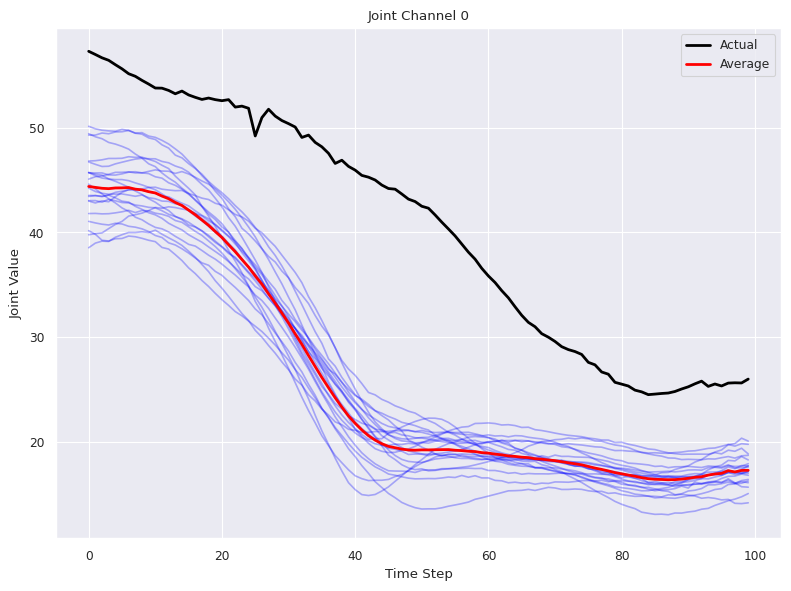

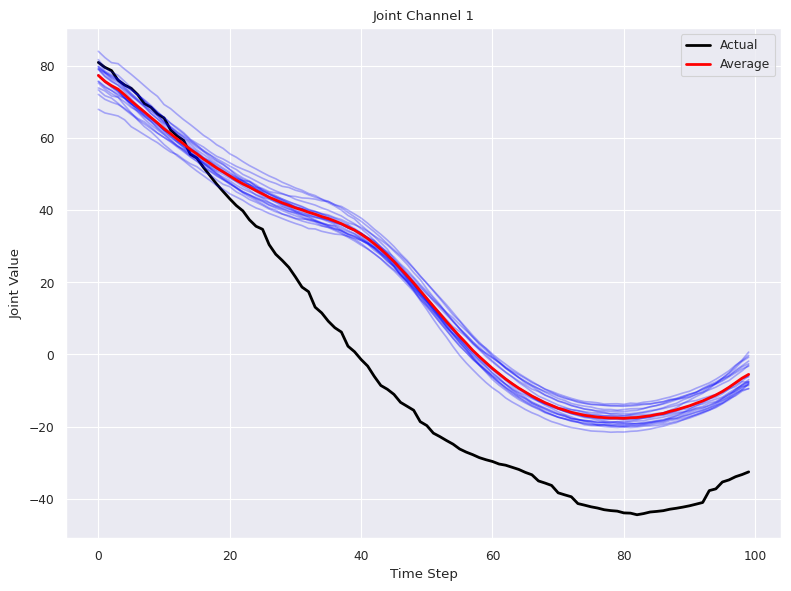

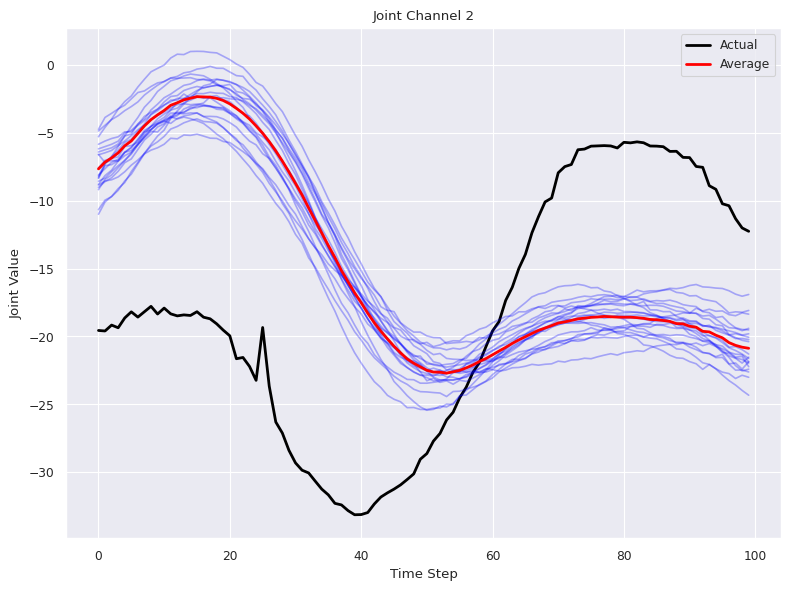

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Function to unscale joints
def unscale_joints(scaled_data, joint_ranges, joint_names):
    unscaled = scaled_data.copy()
    for i, ch in enumerate(joint_names):
        min_val, max_val = joint_ranges[ch]
        unscaled[:, i] = 0.5 * (unscaled[:, i] + 1.0) * (max_val - min_val) + min_val
    return unscaled

# Joint ranges dictionary
joint_ranges = {
    'elbow_flex_r': (0, 150),
    'arm_flex_r': (-90, 180),
    'arm_add_r': (-120, 90),
}

# Use the trained model
model = trained_model
model.eval()

# Same noise_scheduler as in training
num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    beta_schedule="squaredcos_cap_v2",
    clip_sample=True,
    prediction_type="epsilon"
)
noise_scheduler.set_timesteps(num_diffusion_iters)

# Grab a batch from the test loader
obs_batch, joint_batch = next(iter(test_loader))

# Adjust data shape as needed
obs_batch = obs_batch.squeeze(1).float().to(device)   # [B, T, obs_channels]
joint_batch = joint_batch.squeeze(1).float().to(device)  # [B, T, joint_channels]

# Use the first sample for plotting
obs_sample = obs_batch[0:1]
joint_sample = joint_batch[0:1]
B, T, joint_channels = joint_sample.shape

# Flatten observation for FiLM conditioning
global_cond = obs_sample.reshape(B, -1)

# Generate multiple predictions
num_samples = 20
predictions = []

# Ensure scheduler tensors are on the correct device
noise_scheduler.timesteps = noise_scheduler.timesteps.to(device)
noise_scheduler.alphas_cumprod = noise_scheduler.alphas_cumprod.to(device)

for _ in range(num_samples):
    sample = torch.randn_like(joint_sample)
    for step_id in noise_scheduler.timesteps:
        t = torch.tensor([step_id], device=noise_scheduler.alphas_cumprod.device)
        noise_pred = model(sample, t, global_cond)
        step_output = noise_scheduler.step(noise_pred, t, sample)
        sample = step_output.prev_sample
    predictions.append(sample.detach().cpu().numpy()[0])

# Compute the average of the predictions
avg_prediction = sum(predictions) / len(predictions)

# Unscale both predictions and ground truth
joint_names = joint_ranges.keys()
predictions_unscaled = [unscale_joints(pred, joint_ranges, joint_names) for pred in predictions]
avg_prediction_unscaled = unscale_joints(avg_prediction, joint_ranges, joint_names)
true_unscaled = unscale_joints(joint_sample.detach().cpu().numpy()[0], joint_ranges, joint_names)

# Plot each joint channel
time_steps = range(T)
for c in range(joint_channels):
    plt.figure(figsize=(8, 6))

    # Plot unscaled ground truth
    plt.plot(time_steps, true_unscaled[:, c], label="Actual", color="black", linewidth=2)

    # Overlay unscaled predictions
    for pred_unscaled in predictions_unscaled:
        plt.plot(time_steps, pred_unscaled[:, c], alpha=0.3, color="blue")

    # Plot unscaled average prediction
    plt.plot(time_steps, avg_prediction_unscaled[:, c], label="Average", color="red", linewidth=2)

    plt.title(f"Joint Channel {c}")
    plt.xlabel("Time Step")
    plt.ylabel("Joint Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


<ipython-input-28-a5700a98e10b>:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10")  # Use colormap for different step configurations


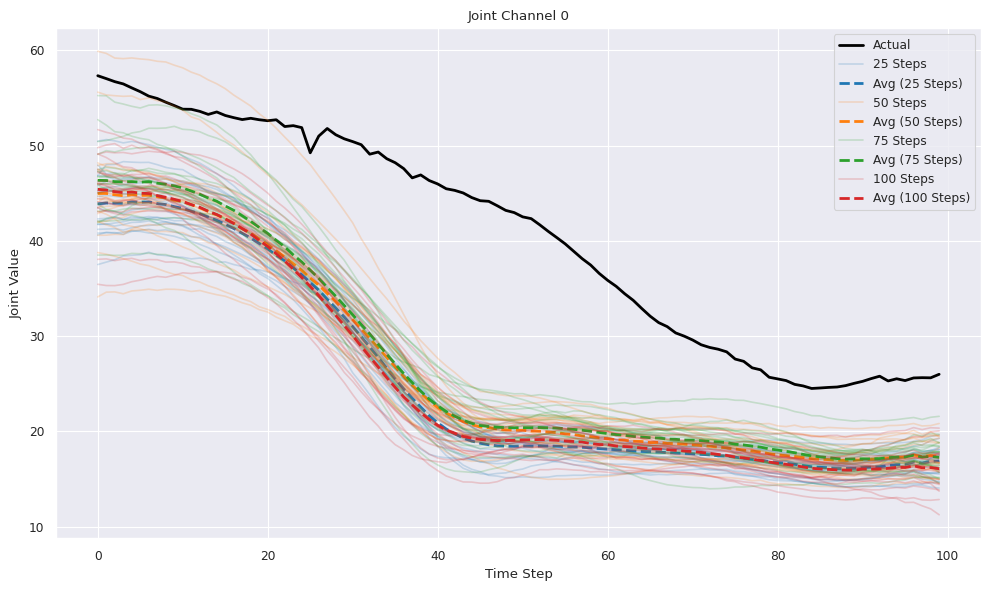

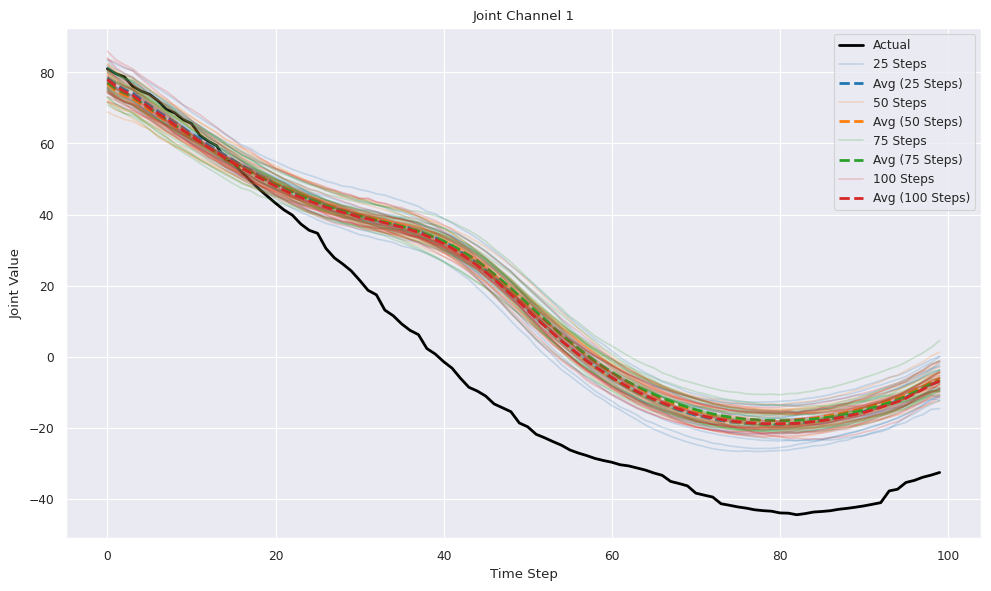

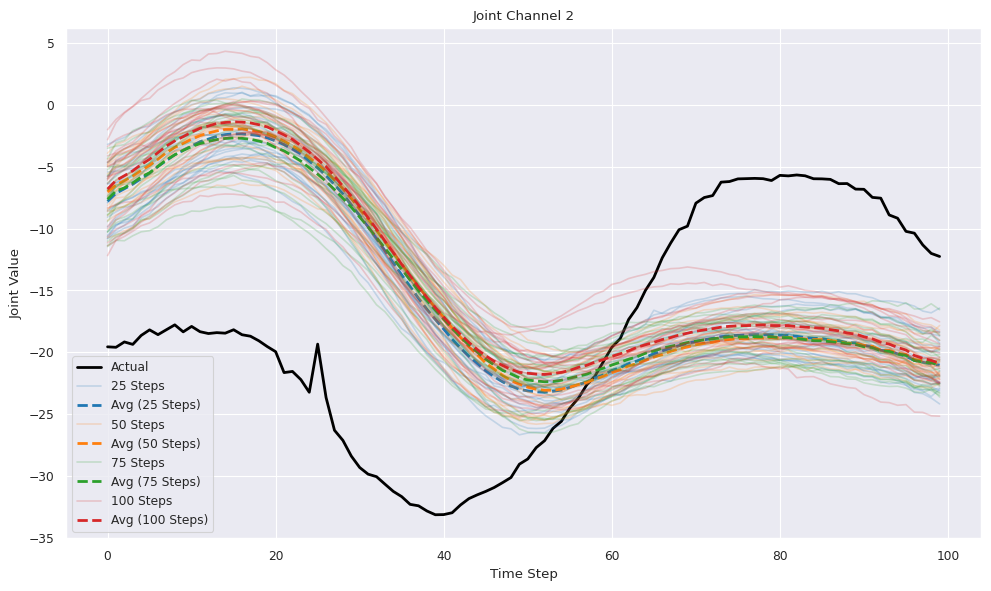

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Function to unscale joints
def unscale_joints(scaled_data, joint_ranges, joint_names):
    unscaled = scaled_data.copy()
    for i, ch in enumerate(joint_names):
        min_val, max_val = joint_ranges[ch]
        unscaled[:, i] = 0.5 * (unscaled[:, i] + 1.0) * (max_val - min_val) + min_val
    return unscaled

# Joint ranges dictionary
joint_ranges = {
    'elbow_flex_r': (0, 150),
    'arm_flex_r': (-90, 180),
    'arm_add_r': (-120, 90),
}

# Use the trained model
model = trained_model
model.eval()

# Define different numbers of inference steps (must not exceed training timesteps)
inference_steps_list = [25, 50, 75, 100]

# Grab a batch from the test loader
obs_batch, joint_batch = next(iter(test_loader))

# Adjust data shape as needed
obs_batch = obs_batch.squeeze(1).float().to(device)   # [B, T, obs_channels]
joint_batch = joint_batch.squeeze(1).float().to(device)  # [B, T, joint_channels]

# Use the first sample for plotting
obs_sample = obs_batch[0:1]
joint_sample = joint_batch[0:1]
B, T, joint_channels = joint_sample.shape

# Flatten observation for FiLM conditioning
global_cond = obs_sample.reshape(B, -1)

# Store predictions for different inference steps
all_predictions_unscaled = []
all_avg_predictions_unscaled = []

# Iterate over different numbers of inference steps
for num_inference_steps in inference_steps_list:
    # Initialize noise scheduler for current inference steps
    noise_scheduler = DDPMScheduler(
        num_train_timesteps=100,  # Match training timesteps
        beta_schedule="squaredcos_cap_v2",
        clip_sample=True,
        prediction_type="epsilon"
    )
    # Subsample timesteps for inference
    noise_scheduler.set_timesteps(num_inference_steps)
    noise_scheduler.timesteps = noise_scheduler.timesteps.to(device)
    noise_scheduler.alphas_cumprod = noise_scheduler.alphas_cumprod.to(device)

    predictions = []
    for _ in range(20):  # Number of samples per inference step configuration
        sample = torch.randn_like(joint_sample)
        for step_id in noise_scheduler.timesteps:
            t = torch.tensor([step_id], device=noise_scheduler.alphas_cumprod.device)
            noise_pred = model(sample, t, global_cond)
            step_output = noise_scheduler.step(noise_pred, t, sample)
            sample = step_output.prev_sample
        predictions.append(sample.detach().cpu().numpy()[0])

    # Compute the average prediction
    avg_prediction = sum(predictions) / len(predictions)

    # Unscale predictions
    joint_names = joint_ranges.keys()
    predictions_unscaled = [unscale_joints(pred, joint_ranges, joint_names) for pred in predictions]
    avg_prediction_unscaled = unscale_joints(avg_prediction, joint_ranges, joint_names)

    # Store unscaled predictions
    all_predictions_unscaled.append(predictions_unscaled)
    all_avg_predictions_unscaled.append(avg_prediction_unscaled)

# Unscale the ground truth
true_unscaled = unscale_joints(joint_sample.detach().cpu().numpy()[0], joint_ranges, joint_ranges.keys())

# Plot each joint channel
time_steps = range(T)
cmap = get_cmap("tab10")  # Use colormap for different step configurations
for c in range(joint_channels):
    plt.figure(figsize=(10, 6))

    # Plot unscaled ground truth
    plt.plot(time_steps, true_unscaled[:, c], label="Actual", color="black", linewidth=2)

    # Plot predictions for each inference step configuration
    for idx, (predictions_unscaled, avg_prediction_unscaled) in enumerate(zip(all_predictions_unscaled, all_avg_predictions_unscaled)):
        # Individual predictions
        for pred_unscaled in predictions_unscaled:
            plt.plot(
                time_steps,
                pred_unscaled[:, c],
                alpha=0.2,
                color=cmap(idx),
                label=f"{inference_steps_list[idx]} Steps" if pred_unscaled is predictions_unscaled[0] else None
            )

        # Average prediction
        plt.plot(
            time_steps,
            avg_prediction_unscaled[:, c],
            color=cmap(idx),
            linewidth=2,
            linestyle="--",
            label=f"Avg ({inference_steps_list[idx]} Steps)"
        )

    plt.title(f"Joint Channel {c}")
    plt.xlabel("Time Step")
    plt.ylabel("Joint Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [1]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import numpy as np

def calculate_rmse_and_pcc(model, test_loader, noise_scheduler, joint_ranges, num_samples=20, device="cpu"):
    model.eval()
    noise_scheduler.timesteps = noise_scheduler.timesteps.to(device)
    noise_scheduler.alphas_cumprod = noise_scheduler.alphas_cumprod.to(device)

    joint_names = list(joint_ranges.keys())
    num_joints = len(joint_names)
    total_rmse = 0.0
    total_pcc = 0.0
    num_batches = 0

    # To accumulate channel-wise metrics
    channel_rmse = np.zeros(num_joints)
    channel_pcc = np.zeros(num_joints)
    channel_counts = np.zeros(num_joints)

    for obs_batch, joint_batch in test_loader:
        # Adjust data shape
        obs_batch = obs_batch.squeeze(1).float().to(device)   # [B, T, obs_channels]
        joint_batch = joint_batch.squeeze(1).float().to(device)  # [B, T, joint_channels]
        B, T, joint_channels = joint_batch.shape

        # Collect predictions for all samples in the batch
        batch_rmse = []
        batch_pcc = []
        for b in range(B):
            obs_sample = obs_batch[b:b+1]  # [1, T, obs_channels]
            joint_sample = joint_batch[b:b+1]  # [1, T, joint_channels]
            global_cond = obs_sample.reshape(1, -1)  # Flatten observation for FiLM conditioning

            predictions = []
            for _ in range(num_samples):
                sample = torch.randn_like(joint_sample)  # Start from noise
                for step_id in noise_scheduler.timesteps:
                    t = torch.tensor([step_id], device=noise_scheduler.alphas_cumprod.device)
                    noise_pred = model(sample, t, global_cond)
                    step_output = noise_scheduler.step(noise_pred, t, sample)
                    sample = step_output.prev_sample
                predictions.append(sample.detach().cpu().numpy()[0])

            # Compute the average prediction
            avg_prediction = sum(predictions) / len(predictions)

            # Unscale the ground truth and predicted values
            true_unscaled = unscale_joints(joint_sample.detach().cpu().numpy()[0], joint_ranges, joint_names)
            avg_prediction_unscaled = unscale_joints(avg_prediction, joint_ranges, joint_names)

            # Calculate RMSE and PCC for each joint channel
            for c in range(joint_channels):
                rmse = np.sqrt(mean_squared_error(true_unscaled[:, c], avg_prediction_unscaled[:, c]))
                pcc, _ = pearsonr(true_unscaled[:, c], avg_prediction_unscaled[:, c])

                # Accumulate channel-wise metrics
                channel_rmse[c] += rmse
                channel_pcc[c] += pcc
                channel_counts[c] += 1

                # Accumulate overall batch metrics
                batch_rmse.append(rmse)
                batch_pcc.append(pcc)

        # Aggregate metrics across the batch
        total_rmse += np.mean(batch_rmse)
        total_pcc += np.mean(batch_pcc)
        num_batches += 1

    # Average channel-wise metrics
    avg_channel_rmse = channel_rmse / channel_counts
    avg_channel_pcc = channel_pcc / channel_counts

    # Total averages
    avg_rmse = total_rmse / num_batches
    avg_pcc = total_pcc / num_batches

    return avg_rmse, avg_pcc, avg_channel_rmse, avg_channel_pcc


# Calculate metrics across the test set
avg_rmse, avg_pcc, avg_channel_rmse, avg_channel_pcc = calculate_rmse_and_pcc(
    model=trained_model,
    test_loader=test_loader,
    noise_scheduler=noise_scheduler,
    joint_ranges=joint_ranges,
    num_samples=5,
    device=device
)

# Print total averages
print(f"Total Average RMSE: {avg_rmse:.4f}")
print(f"Total Average PCC: {avg_pcc:.4f}")

# Print channel-wise averages
for i, joint_name in enumerate(joint_ranges.keys()):
    print(f"{joint_name} - RMSE: {avg_channel_rmse[i]:.4f}, PCC: {avg_channel_pcc[i]:.4f}")


NameError: name 'trained_model' is not defined